In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


**Importing all required librabries **

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


**Path of  test and train dataset **

In [3]:
! ls ../input/digit-recognizer

sample_submission.csv  test.csv  train.csv


**Load train and test data **

In [4]:
# create the training & test sets, skipping the header row with [1:]
train = pd.read_csv("../input/digit-recognizer/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test= pd.read_csv("../input/digit-recognizer/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

In [7]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

The output variable is an integer from 0 to 9. This is a multiclass classification problem.

**Data Visualization**

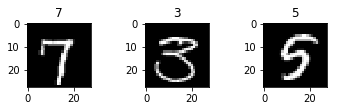

In [8]:
#Convert train datset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [9]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_train.shape

(42000, 28, 28, 1)

In [10]:
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape

(28000, 28, 28, 1)

**Preprocessing the digit images**

**Feature Standarization**

In [11]:
#It is important preprocessing step. It is used to centre the data around zero mean and unit variance
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

**One hot encoding of labels**

A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the nth digit will be represented as a vector which is 1 in the nth dimension.

For example, 3 would be [0,0,0,1,0,0,0,0,0,0]

In [12]:
from keras.utils.np_utils import to_categorical
y_train= to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

/opt/conda/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


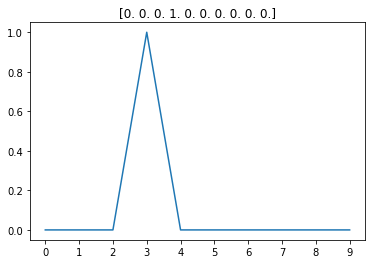

In [13]:
plt.title(y_train[9])
plt.plot(y_train[9])
plt.xticks(range(10));

**Designing neural network architecture **

In [14]:
 #fix random seed for reproducibility
seed = 43
np.random.seed(seed)

**linear Model **

In [15]:
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

Lets create a simple model from Keras Sequential layer.

Lambda layer performs simple arithmetic operations like sum, average, exponentiation etc.

In 1st layer of the model we have to define input dimensions of our data in (rows,columns,colour channel) format. (In theano colour channel comes first)

Flatten will transform input into 1D array.
Dense is fully connected layer that means all neurons in previous layers will be connected to all neurons in fully connected layer. In the last layer we have to specify output dimensions/classes of the model. Here it's 10, since we have to output 10 different digit labels.

In [16]:
model= Sequential()
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

input shape  (None, 28, 28, 1)
output shape  (None, 10)


Before making network ready for training we have to make sure to add below things:

1. A loss function: to measure how good the network is

2. An optimizer: to update network as it sees more data and reduce loss value

3. Metrics: to monitor performance of network

In [17]:
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
 loss='categorical_crossentropy',
 metrics=['accuracy'])

In [18]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()

**Cross Validation **

In [19]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [20]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/3
37800/37800 [==============================] - 111s 3ms/step - loss: 0.2407 - accuracy: 0.9338 - val_loss: 0.4734 - val_accuracy: 0.9100
Epoch 2/3
37800/37800 [==============================] - 111s 3ms/step - loss: 0.2169 - accuracy: 0.9410 - val_loss: 0.4587 - val_accuracy: 0.9092
Epoch 3/3
37031/37800 [============================>.] - ETA: 1s - loss: 0.2115 - accuracy: 0.9425

**Convolution Neural Network **

In [21]:
from keras.layers import Convolution2D, MaxPooling2D

def get_cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [22]:
model= get_cnn_model()
model.optimizer.lr=0.01

AttributeError: can't set attribute

In [23]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
34157/37800 [==========================>...] - ETA: 4:30 - loss: 0.0069 - accuracy: 0.9979

**Data Augmentation**

It is tehnique of showing slighly different or new images to neural network to avoid overfitting. And to achieve better generalization. In case you have very small dataset, you can use different kinds of data augmentation techniques to increase your data size. Neural networks perform better if you provide them more data.

Different data aumentation techniques are as follows:

Cropping
Rotating
Scaling
Translating
Flipping
Adding Gaussian noise to input images etc.

In [24]:
gen =ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [25]:
#model.optimizer.lr=0.001
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
33325/37800 [=========================>....] - ETA: 5:57 - loss: 0.0128 - accuracy: 0.9960

**Adding Batch Normalization**

In [26]:
from keras.layers.normalization import BatchNormalization

def get_bn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
model= get_bn_model()
#model.optimizer.lr=0.01
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
37800/37800 [==============================] - 4041s 107ms/step - loss: 0.0187 - accuracy: 0.9941 - val_loss: 4.1031e-04 - val_accuracy: 0.9916


**Submitting the predictions**

In [28]:
predictions = model.predict_classes(X_test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("DR.csv", index=False, header=True)